In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./src")
import data

----

In [6]:
EXP_CONDITIONS = ["verb", "syntax"]

In [26]:
trials_df = data.get_trials_df(data.load_raw_results(),
                               extract_data_fields=("condition", "stage", "item_idx", "sentence", "scene",
                                                    "verb", "contrast_verbs", "nonce_verb",
                                                    "response", "slider_labels"))

# Extract train--test sequences
trials_df["is_train_trial"] = False
trials_df["is_test_trial"] = False
trials_df["chunk"] = None
# TODO mark training and test trials more explicitly next time ..
train_trial_idxs, test_trial_idxs = [], []
train_chunks, test_chunks = [], []
for uid, subj_trials in trials_df.groupby("uniqueid"):
    chunk = -1
    for trial_index, trial in subj_trials.sort_index().iterrows():
        if trial.stage == "instructions":
            # New chunk.
            chunk += 1
        elif trial.stage == "train":
            # Training trial.
            trials_df.loc[trial_index, ["is_train_trial", "chunk"]] = True, chunk
        elif trial.stage == "test":
            trials_df.loc[trial_index, ["is_test_trial", "chunk"]] = True, chunk

train_trials_df = trials_df[trials_df.is_train_trial]
test_trials_df = trials_df[trials_df.is_test_trial]
len(train_trials_df), len(test_trials_df)

(12, 6)

In [27]:
test_trials_df["response"] = test_trials_df.response.astype(np.float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
# Compute the number of training trials per chunk
chunk_train_sizes = train_trials_df.chunk.value_counts().unique()
assert len(chunk_train_sizes) == 1, "Some chunks are different sizes than others -- huh?\n" + str(train_trials_df.chunk.value_counts())
TRAIN_TRIALS_PER_CHUNK = chunk_train_sizes[0]

In [29]:
train_trials_df.to_csv("data/train_results.csv")

-----

## Demographic analysis

Text(0.5, 0, 'Age')

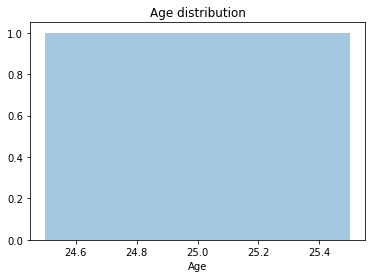

In [30]:
ages = pd.to_numeric(trials_df.loc[1].survey_answer, errors="coerce")

sns.distplot(ages)
plt.title("Age distribution")
plt.xlabel("Age")

In [31]:
trials_df.loc[2].groupby("survey_question_idx").survey_answer.value_counts()

survey_question_idx  survey_answer    
0                    Bachelor's degree    1
1                    Yes                  1
Name: survey_answer, dtype: int64

### Comments

In [32]:
trials_df.loc[27].survey_answer.unique()

array(['tttttt'], dtype=object)

## Reaction time analyses

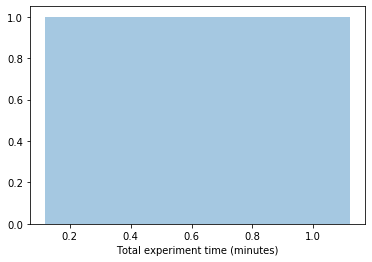

In [33]:
sns.distplot(trials_df.groupby("uniqueid").rt.sum() / 1000 / 60, axlabel="Total experiment time (minutes)")

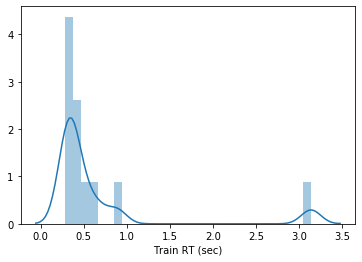

In [34]:
sns.distplot(train_trials_df.rt / 1000, bins=30, axlabel="Train RT (sec)")

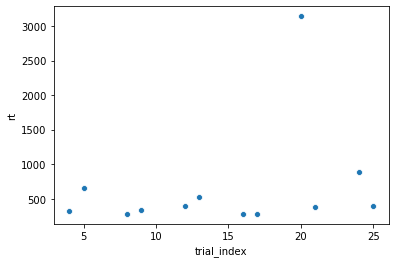

In [35]:
sns.scatterplot(data=train_trials_df.reset_index(), x="trial_index", y="rt")

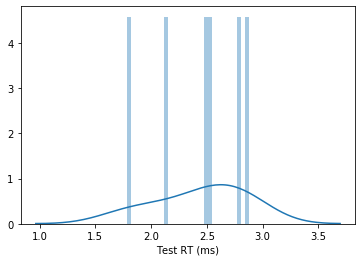

In [36]:
sns.distplot(test_trials_df.rt / 1000, bins=30, axlabel="Test RT (ms)")

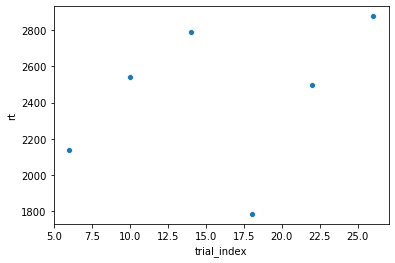

In [37]:
sns.scatterplot(data=test_trials_df.reset_index(), x="trial_index", y="rt")

## Coarse slider analyses

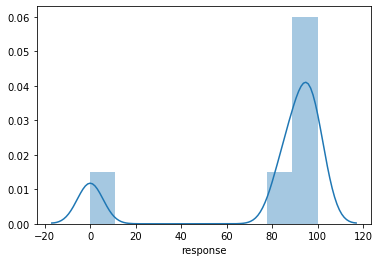

In [38]:
sns.distplot(test_trials_df.response.astype(np.float))

In [39]:
test_trials_df["response_normalized"] = test_trials_df.groupby("uniqueid").response.apply(lambda rs: (rs - rs.mean()) / rs.std())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


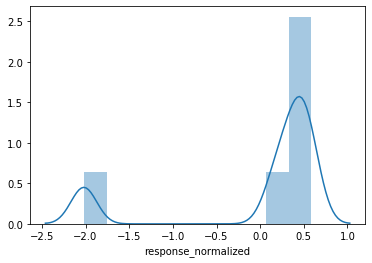

In [40]:
sns.distplot(test_trials_df["response_normalized"], bins=10)

In [51]:
def get_distance_from_ideal_slider(test_row):
    # Was the correct verb on the left or right?
    correct_verb_side = test_row.slider_labels.index(test_row.verb)
    # What is the ideal answer in slider position terms?
    correct_verb_position = 100 * correct_verb_side
    return np.abs(test_row.response - correct_verb_position)
    
test_trials_df["distance_from_ideal_slider"] = test_trials_df.apply(get_distance_from_ideal_slider, axis=1)

# If decision threshold = 50, calculate binary correctness.
test_trials_df["correct"] = test_trials_df.distance_from_ideal_slider < 50

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [52]:
test_trials_df.to_csv("data/test_results.csv")

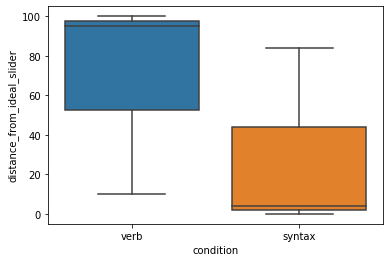

In [53]:
sns.boxplot(data=test_trials_df, x="condition", y="distance_from_ideal_slider")

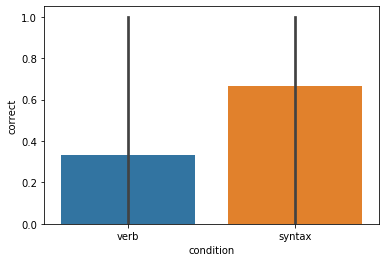

In [54]:
sns.barplot(data=test_trials_df.reset_index(),
            x="condition", y="correct")

In [55]:
test_trials_df.groupby("condition").correct.mean()

condition
syntax    0.666667
verb      0.333333
Name: correct, dtype: float64

In [56]:
test_trials_df.groupby(["item_idx", "condition"]).correct.mean()

item_idx  condition
6.0       verb         False
9.0       syntax        True
11.0      verb          True
12.0      verb         False
14.0      syntax       False
16.0      syntax        True
Name: correct, dtype: bool

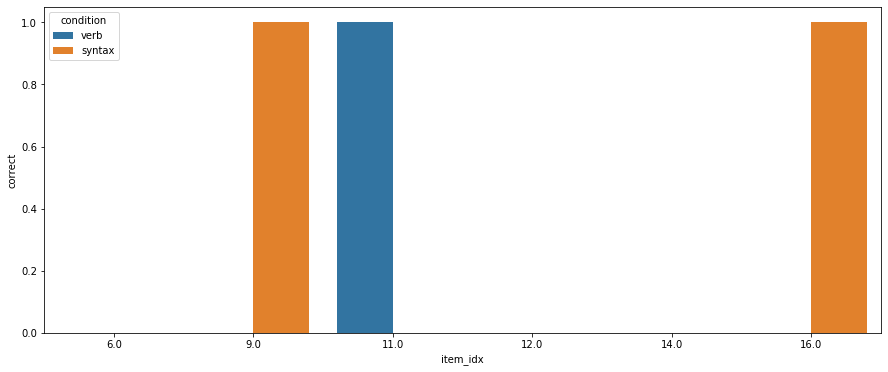

In [57]:
plt.subplots(figsize=(15, 6))
sns.barplot(data=test_trials_df, x="item_idx", hue="condition", y="correct")

Text(0.5, 1.0, 'Total chunk time vs. chunk accuracy')

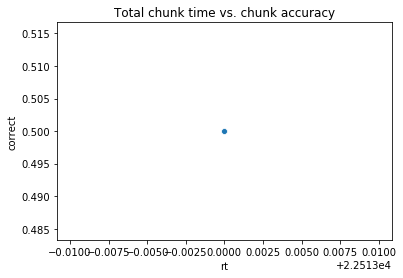

In [58]:
chunk_perf = pd.concat([trials_df.groupby(["uniqueid", "chunk"]).rt.sum(),
                        test_trials_df.groupby(["uniqueid", "chunk"]).correct.mean()],
                       axis=1)

sns.scatterplot(data=chunk_perf, x="rt", y="correct")
plt.title("Total chunk time vs. chunk accuracy")